# Adversarial Attack Vulnerability of Medical Image Analysis Systems: Unexplored Factors
G. Bortsova, C. González-Gonzalo, S. Wetstein, F. Dubost, I. Katramados, L. Hogeweg, B. Liefers, B. van Ginneken, J. Pluim, M. Veta, C. Sánchez, M. de Bruijne. "Adversarial Attack Vulnerability of Medical Image Analysis Systems: Unexplored Factors", Medical Image Analysis, 2021.

# Ophthalmology

This notebook contains the code for crafting and testing black-box attacks corresponding to the Ophthalmology application: **detection of referable diabetic retinopathy (DR) in color fundus (CF) images**.

The notebook makes use of the folder structure and some of the files in the data repository available at: *add Zenodo link*. In that repository:

The **metadata** folder contains:
- CSV file (*kaggle_all_array_labels_bin.csv*) with binarized labels (non-referable DR = 0 (stages 0 and 1) and referable DR = 1 (stages 2 to 4)) for all images in the [Kaggle DR dataset](https://www.kaggle.com/c/diabetic-retinopathy-detection). 
- CSV files with the filenames of the images included in each data partition used in the paper:
    - Development sets: *d1*, *d2*, and *d3* (equivalent top *d2/2*), and the corresponding filenames used for training (*t1*, *t2*, *t3*) and validation (*v1*, *v2*, *v3*) in each development set.
    - Test set

In [1]:
metadata_folder = 'metadata/'

The **data** folder contains 2 example images (one with referable DR label and one with non-referable DR label) from the [Kaggle DR dataset](https://www.kaggle.com/c/diabetic-retinopathy-detection) included in the test set from the publication. 

In [2]:
data_folder = 'data/'

The **models** folder contains all the models trained for the publication that served as target or surrogate models in the black-box adversarial settings, plus the optimal referable/non-referable thresholds computed from the corresponding validation set (threshold that maximizes sensitivity and specificity).

In [3]:
models_folder = 'models/'

------

In [4]:
import os
from PIL import Image
import numpy as np
import csv
import matplotlib.pyplot as plt
import pickle

from keras.models import Model, load_model

from cfi_preprocessing import Preprocess
from attacks_crafting import craft_attack, generate_control_noise
from aux_functions import normalize, ref_nonref, get_adv_noise

Using TensorFlow backend.


## 1) Select and preprocess original image
Load original image and create prprocessed 512x512 RGB image, which is the expected input to the trained target and surrogate models.

In [5]:
!ls {data_folder}

26792_left.jpeg  28275_left.jpeg  preproc


Select image.

In [6]:
fn = '28275_left.jpeg'

Load label.

In [7]:
with open(os.path.join(metadata_folder, 'kaggle_all_array_labels_bin.csv') , 'r') as f:
    labels = {k:int(v) for k, v in csv.reader(f)}
label = labels[fn.split('.')[0]]

Create new folder for storing preprocessed data and preprocess and save selected file.

In [8]:
os.makedirs(os.path.join(data_folder,'preproc', 'rgb'), exist_ok=True)
p = Preprocess(os.path.join(data_folder,fn), threshold=10)
p.process()
p.export_rgb(os.path.join(data_folder, 'preproc', 'rgb'))

/usr/local/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [9]:
img = p.data_scale.astype(np.uint8)

Show preprocessed image and corresponding label:

Original label:  1  ->  Referable DR


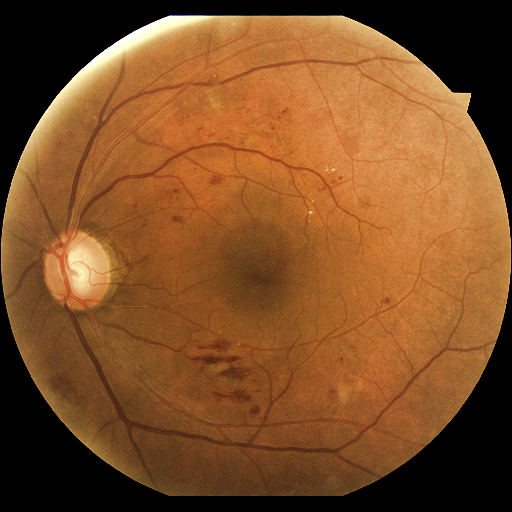

In [10]:
print('Original label: ', label, ' -> ', ref_nonref(label, 0.5))
Image.fromarray(img)

## 2) Load surrogate model

Load surrogate model that will be used to craft the adversarial attacks in the black-box setting. These are the different architectures, development sets, and initialization configurations that were used for the surrogate models in the different experiments of the publication.

- architecture:
    - 'IV3'
    - 'DenseNet121'
- dev_set:
    - d1
    - 'd1_bis' (for black-box setting with same architecture)
    - 'd2'
    - 'd3' (equivalent to d2/2)
- config:
    - 'pretrained' (model initialized with ImageNet pretraining)
    - 'heinit' (model randomly initialized with He initializer)

Define here chosen surrogate configuration and load model.

In [11]:
surrogate_architecture = 'IV3'
surrogate_dev_set = 'd1_bis'
surrogate_config = 'pretrained'

In [12]:
surrogate_folder = os.path.join(models_folder, surrogate_architecture, surrogate_config+'_'+surrogate_dev_set)
print(surrogate_folder)
surrogate_model = load_model(os.path.join(surrogate_folder, 'opt_model.h5'))
surrogate_model.summary()

models/IV3/pretrained_d1_bis
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


## 3) Craft adversarial attack

### Define attack configuration

These are the different attack configurations used in the different black-box adversarial settings of the publication.

- FGSM:
    - Config1: 1 step, alpha 0.01, epsilon 0.01
    - Config2: 1 step, alpha 0.02, epsilon 0.02
    - Config3: 1 step, alpha 0.03, epsilon 0.03
    - Config4: 1 step, alpha 0.04, epsilon 0.04
    - Config5: 1 step, alpha 0.05, epsilon 0.05
    - Config6: 1 step, alpha 0.06, epsilon 0.06
- PGD:
    - Config1: 20 steps, alpha 0.01, epsilon 0.01
    - Config2: 20 steps, alpha 0.01, epsilon 0.02
    - Config3: 20 steps, alpha 0.01, epsilon 0.03
    - Config4: 20 steps, alpha 0.01, epsilon 0.04
    - Config5: 20 steps, alpha 0.01, epsilon 0.05
    - Config6: 20 steps, alpha 0.01, epsilon 0.06

In order to generate the **control noise** version (adversarial noise spatially shuffled), set the variable *control_noise* to True.

Select attack configuration:

In [13]:
attack_method = 'FGSM'
attack_config = 'config2'
config_dict = {"steps": 1, "alpha": 0.02, "epsilon": 0.02}
control_noise = True

Create folder where adversarial examples will be stored.

In [14]:
adv_folder = os.path.join('crafted_attacks', surrogate_architecture, surrogate_config+'_'+ surrogate_dev_set, 
                          attack_method+'_'+attack_config)
os.makedirs(adv_folder, exist_ok=True)

### Craft attack

Performing  FGSM  attack
epsilon:  0.02
alpha:  0.02
steps:  1
Attack crafted!
Crafted adversarial example:


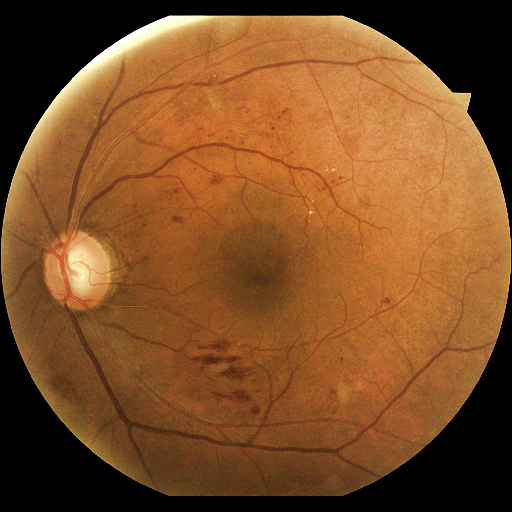

In [15]:
img_adv = craft_attack(img, label, surrogate_model, attack_method, attack_config, config_dict)

#Save adversarial image
Image.fromarray(img_adv).save(os.path.join(adv_folder, fn.split('.')[0]+'_adv.png'))

print('Crafted adversarial example:')
Image.fromarray(img_adv)

Generated image with control noise:


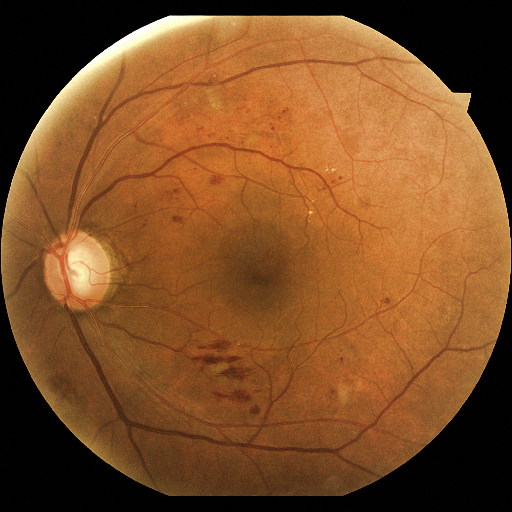

In [16]:
if control_noise:
    img_control_noise = generate_control_noise(img, img_adv)
    
    #Save control noise image
    Image.fromarray(img_control_noise).save(os.path.join(adv_folder, fn.split('.')[0]+'_control.png'))
    
    print('Generated image with control noise:')
    display(Image.fromarray(img_control_noise))

## 4) Load target model

Load target model that will be attacked in the black-box setting. These are the different architectures, development sets, and initialization configurations that were used for the target models in the different experiments of the publication.

- architecture:
    - 'IV3'
    - 'DenseNet121'
- dev_set:
    - 'd1'
    - 'd1_10' (equivalent to d1/10)
- config:
    - 'pretrained' (model initialized with ImageNet pretraining)
    - 'heinit' (model randomly initialized with He initializer)

Define here chosen surrogate configuration and load model.

In [17]:
target_architecture = 'IV3'
target_dev_set = 'd1'
target_config = 'pretrained'

In [18]:
target_folder = os.path.join(models_folder, target_architecture, target_config+'_'+target_dev_set)
print(target_folder)
target_model = load_model(os.path.join(target_folder, 'opt_model.h5'))
target_model.summary()

models/IV3/pretrained_d1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


Load optimal referable/non-referable threshold computed from corresponding validation set (threshold that maximizes sensitivity and specificity).

In [19]:
with open(os.path.join(target_folder,'opt_th.pickle'), 'rb') as handle:
    target_opt_th = pickle.load(handle) 
print(target_opt_th)

0.4631668


## 5) Attack target model

### Obtain predictions in clean and adversarial setting

In [20]:
orig_pred = target_model.predict((normalize(img))[np.newaxis])
orig_pred = orig_pred[:,1][0]

In [21]:
adv_pred = target_model.predict((normalize(img_adv))[np.newaxis])
adv_pred = adv_pred[:,1][0]

In [22]:
print('Original label: ', label, ' -> ', ref_nonref(label, 0.5))
print('Clean prediction: ', orig_pred, ' -> ', ref_nonref(orig_pred, target_opt_th))
print('Adversarial prediction: ', adv_pred, ' -> ', ref_nonref(adv_pred, target_opt_th))

Original label:  1  ->  Referable DR
Clean prediction:  0.999025  ->  Referable DR
Adversarial prediction:  0.08362261  ->  Non-referable DR


In [23]:
if control_noise:
    control_pred = target_model.predict((normalize(img_control_noise))[np.newaxis])
    control_pred = control_pred[:,1][0]      
    print('Control noise prediction: ', control_pred, ' -> ', ref_nonref(control_pred, target_opt_th))                                   

Control noise prediction:  0.99884474  ->  Referable DR


Get adversarial noise for visualization. The adversarial noise is equivalent to the difference between the original and the adversarial image.

In [24]:
adv_noise = get_adv_noise(img, img_adv)

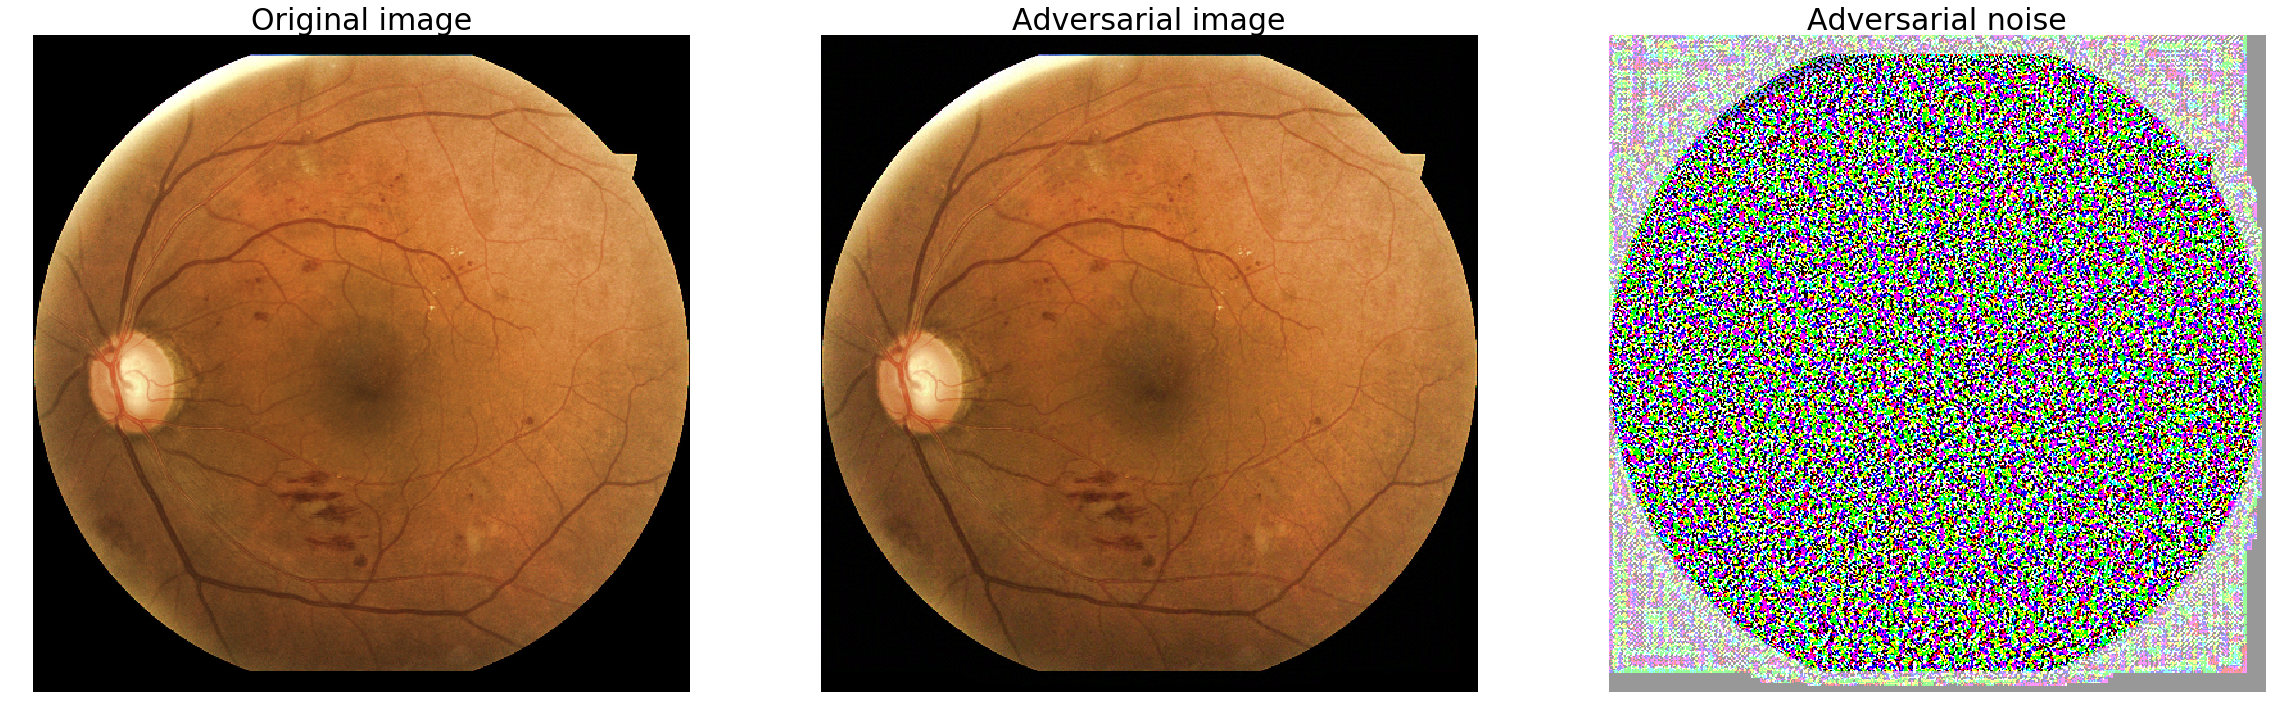

In [25]:
fig, axes = plt.subplots(1,3, figsize=(40, 40))
for ax in axes:
    ax.set_axis_off()
axes[0].imshow(img)
axes[0].set_title('Original image', size=30)
axes[1].imshow(img_adv)
axes[1].set_title('Adversarial image', size=30)
axes[2].imshow(adv_noise)
axes[2].set_title('Adversarial noise', size=30)
plt.show()